# Transport Test

In [1]:
import math
import json
import os

import h5py
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from scipy.constants import physical_constants
from scipy.interpolate import interp1d
from scipy.ndimage.filters import median_filter, gaussian_filter
from scipy.optimize import curve_fit
from matplotlib import gridspec

from sde_util import *
# from sep_10th import *

plt.rcParams['figure.dpi'] = 200

rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

tableau_colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

In [2]:
cwd = os.getcwd()

## MHD Simulaton Information

In [3]:
def extend_mhd_info(mhd_run):
    """Extend mhd_info based on the SDE runs
    """
    # normalizations
    L0 = 5.0E6  # in m
    b0 = 50.0  # in Gauss
    n0 = 1.0e10  # number density in cm^-3
    lscale = 1.0
    bscale = 1.0
    L0 *= lscale
    b0 *= bscale
    n0 *= bscale**2  # to keep the Alfven speed unchanged
    va = calc_va_cgs(n0, b0) / 1E2  # m/s
    t0 = L0 / va  # in sec
    normalization = {"L0": L0, "b0": b0, "n0": n0, "va": va, "t0": t0}
    filename = cwd + "/mhd_runs_for_sde.json"
    with open(filename, 'r') as fh:
        configs = json.load(fh)
    mhd_run_dir = configs[mhd_run]["run_dir"]
    config_tmp = load_mhd_config(mhd_run_dir)  # MHD configuration for SDE runs
    keys = config_tmp.dtype.names
    mhd_config_for_sde = {key: config_tmp[key][0] for key in keys}
    mhd_config_for_sde.update(configs[mhd_run])
    mhd_info = get_mhd_info(mhd_run_dir, configs[mhd_run]["config_name"])
    mhd_info["norm"] = normalization
    # get the time intervals for different outputs
    for i in range(1, 100):
        vname = "output" + str(i)
        if vname in mhd_info:
            dtv = "dt_" + mhd_info[vname]["file_type"]
            mhd_info[dtv] = mhd_info[vname]["dt"] * mhd_info["norm"]["t0"]
        else:
            break
    mhd_info.update(mhd_config_for_sde)
    return mhd_info

In [4]:
mhd_run = "test_periodic_bc"
mhd_info = extend_mhd_info(mhd_run)

## Global Energy Spectrum

In [5]:
def plot_global_spectra(sde_run_config):
    """Plot global spectra

    Arguments:
        sde_run_config (dict): SDE run configuration
    """
    kwargs = {
        "color": 'r',
        "show_plot": False,
        "plot_power": True,
        "power_test": False
    }
    tmin = sde_run_config["tmin"]
    tmax = sde_run_config["tmax"]

    ebins_kev, debins_kev = get_ebins_kev(sde_run_config)
    run_name = sde_run_config["run_name"]
    spl = run_name.split("/")
    mhd_run = spl[0]
    sde_run = spl[1]

    rect = [0.16, 0.16, 0.8, 0.8]
    fig1 = plt.figure(figsize=[3.5, 2.5])
    ax1 = fig1.add_axes(rect)
    for tframe in range(tmin, tmax + 1):
        pbins, pbins_edge, fp = read_momentum_dist(run_name, tframe)
        dnptl_bins = fp * pbins**2
        dpbins = np.diff(pbins_edge)  # the bins sizes
        dnptl_bins *= dpbins  # number of particles in each bin
        fe = dnptl_bins / debins_kev
        kwargs["plot_power"] = False
        kwargs["color"] = plt.cm.jet((tframe - tmin) / float(tmax - tmin), 1)
        plot_energy_spectrum(ebins_kev, fe, ax1, sde_run_config, **kwargs)
    ax1.tick_params(bottom=True, top=True, left=True, right=True)
    ax1.set_xlabel(r'$\varepsilon/$keV', fontsize=10)
    ax1.set_ylabel(r'$f(\varepsilon)$', fontsize=10)
    ax1.tick_params(labelsize=8)
    ax1.grid(True)
    fdir = "../img/global_spectrum/" + mhd_run + "/"
    mkdir_p(fdir)
    # fname = fdir + "espect_" + sde_run + ".pdf"
    # fig1.savefig(fname)
    fname = fdir + "espect_" + sde_run + ".jpg"
    fig1.savefig(fname, dpi=400)
    plt.show()

In [6]:
# Load the configration for SDE runs
with open('spectrum_config.json', 'r') as file_handler:
    config = json.load(file_handler)

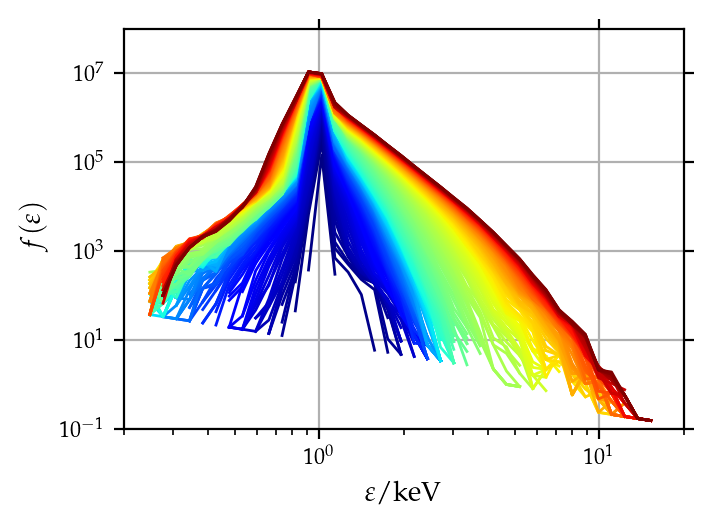

In [7]:
sde_run = "transport_test_run"
run_name = mhd_run + "/" + sde_run
sde_run_config = config[run_name]
p0 = 0.1
e0 = sde_run_config["e0"] / (0.5*p0**2)
sde_run_config["tmax"] = 200
plot_global_spectra(sde_run_config)

## Distributions of different energy bands

In [8]:
def spatial_distribution(plot_config, mhd_info, sde_run_config, verbose=True, show_plot=True):
    """Plot spatial distribution for multi energy bands

    Arguments:
        plot_config (dict): plot configuration in dictionary
        mhd_info (dict): MHD simulation information
    """
    tframe = plot_config["tframe"]
    nghost = mhd_info["nghost"]
    nx_mhd = mhd_info["nx"]
    ny_mhd = mhd_info["ny"]
    nxg = nx_mhd + 2 * nghost
    nyg = ny_mhd + 2 * nghost
    dx = mhd_info["dx"]
    dy = mhd_info["dy"]

    fig = plt.figure(figsize=[6.5, 3])
    gs = gridspec.GridSpec(1,
                           5,
                           wspace=0,
                           hspace=0,
                           top=0.92,
                           bottom=0.14,
                           left=0.08,
                           right=0.98)
    sizes = [
        mhd_info["xmin"],
        mhd_info["xmax"],
        mhd_info["ymin"],
        mhd_info["ymax"]
    ]
    L0_Mm = mhd_info["norm"]["L0"] / 1E6
    sizes = np.asarray(sizes) * L0_Mm
    lx = sizes[1] - sizes[0]
    ly = sizes[3] - sizes[2]
    xmid = 0.5 * (sizes[0] + sizes[1])
    xmin_in = sizes[0] * 0.5
    xmax_in = sizes[1] * 0.5
    ymin_in = sizes[2]
    ymax_in = sizes[3]
    ixs = int(xmin_in * nx_mhd / lx)
    ixe = int(xmax_in * nx_mhd / lx)
    iys = int(ymin_in * ny_mhd / ly)
    iye = int(ymax_in * ny_mhd / ly)
    mhd_run_dir = mhd_info["run_dir"]
    fpath = mhd_run_dir + 'bin_data/'
    xmid = (xmin_in + xmax_in) / 2
    sizes_in = [xmin_in-xmid, xmax_in-xmid, ymin_in, ymax_in]
    
    fnorms = [1, 1E1, 1E2, 1E3]

    tframe_str = str(tframe).zfill(4)
    run_name = sde_run_config["run_name"]
    fname = '../data/' + run_name + '/fxy-' + tframe_str + '_sum.dat'
    fdata = np.fromfile(fname)
    nreduce = sde_run_config["nreduce"]
    nx = nx_mhd // nreduce
    ny = ny_mhd // nreduce
    ixsr = int(xmin_in * nx / lx)
    ixer = int(xmax_in * nx / lx)
    iysr = int(ymin_in * ny / ly)
    iyer = int(ymax_in * ny / ly)
    nbands = int(fdata[0])
    pbins_edges = fdata[1:nbands + 2]
    pinit = 0.1
    pbins_edges /= pinit
    ebins_edges = pbins_edges**2
    if verbose:
        print("data size: %d %d" % (nx, ny))
    ndp, = fdata.shape
    dists = fdata[nbands + 2:].reshape([(ndp - nbands - 2) // (nx * ny), -1])
    if verbose:
        print("Total number of particles: %f" % np.sum(dists))

    fband_ycuts = []
    fband_xcuts = []
    bands, bande = plot_config["high_bands"]
    for iband, eband in enumerate(range(bands, bande + 1)):
        fband = dists[eband, :]
        if verbose:
            print("particle number in band %d: %f" % (eband, np.sum(fband)))
            print(
                "min, max, mean, and std: %f %f %f %f" %
                (np.min(fband), np.max(fband), np.mean(fband), np.std(fband)))
        fband *= fnorms[iband]
        fband = np.reshape(fband, (ny, nx))
        #         fband = fband[:, nx//4:nx*3//4]
        nyl, nxl = fband.shape
        fdata_vcut = np.mean(fband[:, nxl // 2 - 3:nxl // 2 + 4], axis=1)
        iy_hcut = int(nyl * 185 / ly)
        fdata_hcut = np.mean(fband[iy_hcut - 3:iy_hcut + 4, :], axis=0)
        fband_xcuts.append(fdata_hcut)
        fband_ycuts.append(fdata_vcut)
        ax = plt.subplot(gs[0, iband])
        vmin = plot_config['nmin']
        vmax = plot_config['nmax']
        fdata = fband[iysr:iyer, ixsr:ixer] + vmin * 0.1
        img = ax.imshow(fdata,
                        cmap=plt.cm.viridis,
                        aspect='auto',
                        origin='lower',
                        extent=sizes_in,
                        norm=LogNorm(vmin=vmin, vmax=vmax),
                        interpolation='bicubic')
        ax.tick_params(bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='x', which='minor', direction='in')
        ax.tick_params(axis='x', which='major', direction='in')
        ax.tick_params(axis='y', which='minor', direction='in')
        ax.tick_params(axis='y', which='major', direction='in')
        ax.tick_params(labelsize=8)
        ax.set_xlabel(r'$x$ (Mm)', fontsize=10)
        if iband > 0:
            ax.tick_params(axis='y', labelleft=False)
        else:
            ax.set_ylabel(r'$y$ (Mm)', fontsize=10)

        if iband == 0:
            rect = np.asarray(ax.get_position()).flatten()
            rect_cbar = np.copy(rect)
            rect_cbar[0] += 0.01
            rect_cbar[2] = 0.01
            rect_cbar[1] = 0.6
            rect_cbar[3] = 0.2
            cbar_ax = fig.add_axes(rect_cbar)
            cbar = fig.colorbar(img, cax=cbar_ax, extend="both")
            cbar.ax.tick_params(labelsize=6, color='w')
            cbar.ax.yaxis.set_tick_params(color='w')
            cbar.outline.set_edgecolor('w')
            plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
        norm = fnorms[iband]
        e0 = sde_run_config["e0"]
        enel = "{%0.0f}" % (ebins_edges[eband] * e0)
        eneh = "{%0.0f}" % (ebins_edges[eband + 1] * e0)
        ftext = (enel + ' -- ' + eneh + 'keV')
        if norm > 1:
            norm_log = int(math.log10(fnorms[iband]))
            fig_text = r'$10^{' + str(norm_log) + '}n($' + ftext + r'$)$'
        else:
            fig_text = r'$n($' + ftext + r'$)$'
        # cbar.ax.set_ylabel(fig_text, fontsize=12, color='w')
        ax.text(0.5,
                0.95,
                fig_text,
                color=tableau_colors[iband],
                fontsize=6,
                bbox=dict(boxstyle='round',
                          facecolor='w',
                          alpha=1,
                          edgecolor='none',
                          pad=0.2),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)

    ax = plt.subplot(gs[0, 4])
    xgrid = np.linspace(sizes[0], sizes[1], nx)
    ygrid = np.linspace(sizes[2], sizes[3], ny)
    for iband, fband_y in enumerate(fband_ycuts):
        label = 'band ' + str(iband + 1)
        ax.semilogx(fband_y,
                    ygrid,
                    nonpositive="mask",
                    linewidth=1,
                    label=label)
    ax.set_ylim([ymin_in, ymax_in])
    # ax.set_xlim([1E-2, 2E4])
    ax.set_xlim([1E1, 2E3])
    ax.grid(linewidth=0.5)
    ax.set_xlabel('Density', fontsize=10)
    ax.tick_params(axis='y', labelleft=False)
    ax.tick_params(labelsize=8)

    tva = mhd_info["dt_hdf5"] * tframe
    title = r'$t = ' + "{:10.1f}".format(tva) + r' s$'
    plt.suptitle(title, fontsize=12)

    fdir = '../img/' + mhd_run + '/' + sde_run + '/'
    mkdir_p(fdir)
    fname = fdir + 'nrho_high_' + str(tframe) + '.jpg'
    fig.savefig(fname, dpi=200)

    if show_plot:
        plt.show()
    else:
        plt.close('all')

In [9]:
# Load the configration for SDE runs
with open('spectrum_config.json', 'r') as file_handler:
    config = json.load(file_handler)
sde_run = "transport_test_run"
run_name = mhd_run + "/" + sde_run
sde_run_config = config[run_name]

data size: 128 128
Total number of particles: 3200000.000000
particle number in band 4: 1326274.000000
min, max, mean, and std: 0.000000 322.000000 80.949341 88.472657
particle number in band 5: 8319.750000
min, max, mean, and std: 0.000000 9.000000 0.507797 1.135471
particle number in band 6: 4.250000
min, max, mean, and std: 0.000000 0.250000 0.000259 0.008049
particle number in band 7: 0.000000
min, max, mean, and std: 0.000000 0.000000 0.000000 0.000000


/global/homes/x/xiaocan/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/x/xiaocan/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


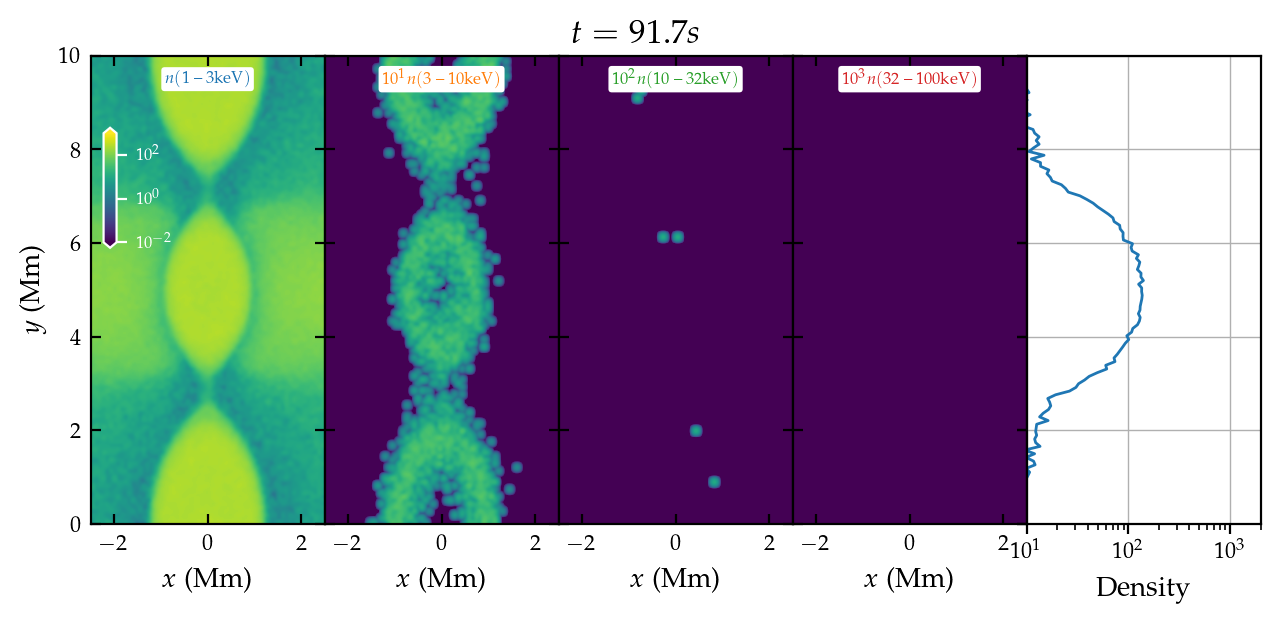

In [10]:
plot_config = {}
if "high_bands" in sde_run_config:
    plot_config["high_bands"] = sde_run_config["high_bands"]
else:
    plot_config["high_bands"] = [4, 7]
plot_config["eband"] = 3
plot_config["tframe"] = 200
plot_config["nmin"] = 1E-2
plot_config["nmax"] = 1E3
spatial_distribution(plot_config, mhd_info, sde_run_config, verbose=True, show_plot=True)